In [2]:
__author__      = "Meike Kuessner"
__institution__ = "Ruhr-Univ. Bochum"
__description__ = "Python Notebook to plot fit results from PAWIAN config file"

In [3]:
pip install uproot

Note: you may need to restart the kernel to use updated packages.


In [4]:
import uproot #needed to read root files
import matplotlib.pyplot as plt
import numpy as np
import math
from mpl_toolkits.axes_grid1 import make_axes_locatable #needed for residual plot to arrange subplots

In [5]:
def Get4Vecs(filename, particlename, datatype): #load four-vectors from file
    file_Px = uproot.open(filename)["_"+datatype+"Fourvecs/"+particlename+"/fP/fP.fX"]
    file_Py = uproot.open(filename)["_"+datatype+"Fourvecs/"+particlename+"/fP/fP.fY"]
    file_Pz = uproot.open(filename)["_"+datatype+"Fourvecs/"+particlename+"/fP/fP.fZ"]
    file_E = uproot.open(filename)["_"+datatype+"Fourvecs/"+particlename+"/fE"]
    return(file_Px, file_Py, file_Pz, file_E)

def GetWeight(filename, datatype): #load weights from file
    file_weight = uproot.open(filename)["_"+datatype+"Fourvecs/weight"]
    return(file_weight)

def Mass(vec): #Calc invariant mass of vector(s)
    M = []
    for i in range(0,len(vec[0][0])):
        px=0.
        py=0.
        pz=0.
        e=0.
        for j in range(0,len(vec)):
            px += vec[j][0][i]
            py += vec[j][1][i]
            pz += vec[j][2][i]
            e  += vec[j][3][i]
        M.append(math.sqrt(e**2-px**2-py**2-pz**2))
    return(M)

def Fill4Vecs(filename, particlename, datatype): #Fill 4Vecs from file
    Vecs = Get4Vecs(filename, particlename, datatype)
    array_4Vecs = [Vecs[0].array(), 
                    Vecs[1].array(), 
                    Vecs[2].array(), 
                    Vecs[3].array()]
    return(array_4Vecs)

def FillWeight(filename, datatype): #Fill Weights from file
    Weights = GetWeight(filename, datatype)
    array_weights = Weights.array()
    return(array_weights)

#Some standard functinos for 4 vectors... Don't hesitate to complete them...

def Boost(vec, boost_vec):
    bx = -boost_vec[0]/boost_vec[3]
    by = -boost_vec[1]/boost_vec[3]
    bz = -boost_vec[2]/boost_vec[3]
    b2 = bx*bx+by*by+bz*bz
    bp = bx*vec[0] + by*vec[1] + bz*vec[2]
    
    if b2<1.0:
        gamma = 1.0 / np.sqrt(1.0 - b2)
    else:
        gamma=0.
    
    gamma2 =  (gamma - 1.0)/b2
  
    result = []
    result.append(vec[0] + gamma2*bp*bx + gamma*bx*vec[3])
    result.append(vec[1] + gamma2*bp*by + gamma*by*vec[3])
    result.append(vec[2] + gamma2*bp*bz + gamma*bz*vec[3])
    result.append(gamma*(bp+vec[3]))
    return(result)

def Perp(vec):
    P = np.sqrt(vec[0]**2+vec[1]**2+vec[2]**2)
    return(P)

def Theta(vec):
    theta = math.acos(vec[2]/Perp(vec))
    return(theta)

def CosTheta(vec):
    cos_theta = math.cos(Theta(vec))
    return(cos_theta)

def Phi(vec):
    phi = math.atan2(round(vec[1],5),round(vec[0],5))
    return(phi)

def RotateZ(vec, angle):
    x = vec[0]
    y = vec[1]
    s = math.sin(angle)
    c = math.cos(angle)
    vec[0] = c*x - s*y
    vec[1] = s*x + c*y
    return(vec)

def RotateY(vec, angle):
    x = vec[0]
    z = vec[2]
    s = math.sin(angle)
    c = math.cos(angle)
    vec[0] = c*x + s*z
    vec[2] = -s*x + c*z
    return(vec)

def HeliVec(motherRef, ref, mother, daughter): #Calc vector in helicity system
    resultvec=daughter
    refTrafovec=ref
    refRecoilTrafovec=[motherRef[0]-ref[0], motherRef[1]-ref[1], motherRef[2]-ref[2], motherRef[3]-ref[3]]
    pi = 3.14159265358979323846
    
    #boost all vectors into the mother rest frame
    result=Boost(resultvec,mother)
    refTrafo=Boost(refTrafovec,mother)
    refRecoilTrafo=Boost(refRecoilTrafovec,mother)
    
    #rotate vectors so that refRecoilTrafo moves in the negative direction of the z-axis   
    result=RotateZ(result,-Phi(refTrafo))
    result=RotateY(result,pi-Theta(refTrafo))

    refRecoilTrafo=RotateZ(refRecoilTrafo,-Phi(refTrafo))
    refRecoilTrafo=RotateY(refRecoilTrafo,pi-Theta(refTrafo))
    
    #rotate around the z-axis so that refRecoil lies in the x-z plain
    result=RotateZ(result,pi-Phi(refRecoilTrafo))
    
    return(result)

def SumLV(sum_array): #sum array of LorentzVectors
    result = []
    for i in range(0,len(sum_array[0][0])):
        px = 0 
        py = 0 
        pz = 0 
        e = 0
        for j in range(0,len(sum_array)):
            px+=sum_array[j][0][i]
            py+=sum_array[j][1][i]
            pz+=sum_array[j][2][i]
            e+=sum_array[j][3][i]
        result.append([px, py, pz, e])
    return(result)
    
def CalcAngles(projectile4Vec, initialP4, combinedMother4Vec, combinedDec4Vec, gamgam): #Calc angular information
    motherRef4Vec = []
    refVec = []
    
    if gamgam == True :
        motherRef4Vec = [3., 0., 0., 10.]
        refVec = [0., 0., Perp(projectile4Vec), projectile4Vec[3]]
        
    if gamgam == False:
        motherRef4Vec = projectile4Vec
        refVec = initialP4
    
    result4Vec = []
    Costheta = []
    Phiangle = []
    
    for i in range(0,len(combinedMother4Vec)):
        combinedMother4vec=[combinedMother4Vec[i][0], combinedMother4Vec[i][1], combinedMother4Vec[i][2], combinedMother4Vec[i][3]]
        combinedDec4vec=[combinedDec4Vec[i][0], combinedDec4Vec[i][1], combinedDec4Vec[i][2], combinedDec4Vec[i][3]]
        
        #result4Vec.append(Boost(combinedMother4vec, combinedDec4vec))
        result4Vec.append(HeliVec(motherRef4Vec, refVec, combinedMother4vec, combinedDec4vec))
        #result4Vec.append(HeliVec(projectile4Vec, motherRef4Vec, combinedMother4vec, combinedDec4vec))
        #result4Vec.append(combinedMother4vec)
        Costheta.append(CosTheta(result4Vec[i]))
        Phiangle.append(Phi(result4Vec[i]))
    return(Costheta,Phiangle,result4Vec)

In [6]:
def GetParticleNames(filename): # read finalStateParticles from cfg file
    cfg = open(filename, "r")
    file = cfg.readlines()
    particlenames = []
    for line in file:
        if "finalStateParticle" in line:
            line = line.replace("finalStateParticle", "")
            line = line. replace("=", "")
            line = line.strip()
            particlenames.append(line)
    return(particlenames)

def ReadCFGFile(filename): 
    # read information from cfg file. Store contribution names which provide file names 
    #and kinematic informationcfrom initial Vector and projectile vector
    
    path = filename.rpartition("/")[0]
    cfg = open(filename, "r")
    file = cfg.readlines()
    contrib_names = []
    file_names = []
    file_name_extension = ""
    initial4Vec = []
    projectile4Vec = []
    gamgamflag = False
    
    for line in file:
        if "calcContribution" in line and not "#" in line:
            line = line.replace("calcContribution", "")
            line = line.replace("=", "")
            line = line.split('withZeroAmp')[0]
            line = line.strip()
            contrib_names.append(line)
        if "name" in line and not "#" in line:
            line = line.replace("name", "")
            line = line.replace("=", "")
            line = line.strip()
            file_name_extension=line
        if "initial4Vec" in line and not "#" in line:
            line = line.replace("initial4Vec","")
            line = line.replace("=","")
            line = line.strip()
            vec = line.split()
            initial4Vec = [float(vec[1]), float(vec[2]), float(vec[3]), float(vec[0])] 
        if "projectile4Vec" in line and not "#" in line:
            line = line.replace("projectile4Vec","")
            line = line.replace("=","")
            line = line.strip()
            vec = line.split()
            projectile4Vec = [float(vec[1]), float(vec[2]), float(vec[3]), float(vec[0])]
        if "productionFormalism" in line and "FormationGamGam" in line and not "#" in line:
            gamgamflag = True
    
    file_names.append(str(path+"/pawianHists"+file_name_extension+".root"))
    for i in range(0,len(contrib_names)): file_names.append(str(path+"/pawianHists"+file_name_extension+contrib_names[i]+".root"))
    
    return(file_names, contrib_names, file_name_extension, initial4Vec, projectile4Vec, gamgamflag)

def ConvertToLatex(phrase): #Convert particle names to Latex code which can be used for plot labels etc.
    latex_phrase = []
    for i in range(0,len(phrase)):
        dummy = phrase[i]
        if "+" in dummy:
            dummy=dummy.replace("+","^{+}")
        if "-" in dummy:
            dummy=dummy.replace("-","^{-}")
        if "0" in dummy:
            dummy=dummy.replace("0","^{0}")
        if "pion" in dummy:
            dummy = dummy.replace("pion","\pi")
        if "etaprime" in dummy:
            dummy = dummy.replace("etaprime","\eta'")
        if "eta" in dummy:
            dummy = dummy.replace("eta","\eta")
        if "phi" in dummy:
            dummy = dummy.replace("phi","\phi")
        if "rho" in dummy:
            dummy = dummy.replace("rho","\rho")
        if "pbar" in dummy:
            dummy = dummy.replace("pbar","\bar{p}")
        if "nbar" in dummy:
            dummy = dummy.replace("nbar","\bar{n}")
        latex_phrase.append(dummy)
    return(latex_phrase)

In [7]:
def DrawContribData(Data, Weight, Color, Name, plot_range, N_bins): #Draw Data Contribution with error bars
    histo = plt.hist(Data, bins = N_bins, range=plot_range, weights=Weight, histtype='step', label = Name, color = Color, linewidth=2.0)
    edges = histo[1]
    entries = histo[0] 
    bin_centers= []
    for i in range(0,len(edges)-1):
        bin_centers.append(0.5 * (edges[i+1] + edges[i]))
    graph = plt.errorbar(bin_centers, entries, yerr=np.sqrt(entries), color = Color, fmt = '.', linewidth=2.0)
    return(N_bins, histo)

def DrawContrib(Data, Weight, Color, Name, plot_range, N_bins): #Draw Fitted Contribution as simple histogram 
    histo = plt.hist(Data, N_bins, range=plot_range, weights=Weight, label = Name, histtype='step', color = Color, linewidth=2.0)
    return(histo)


def DrawAllContribs(vals_data, vals_fit, weights, labels, xlabels, nbins, resid, hist_type): #Draw them all together...
    
    #calc senseful range of x-Axis
    
    if hist_type==1: x_range=[-1., 1.]
    if hist_type==2: x_range=[-3.2, 3.2]

    
    if hist_type==0:
        
        bla = DrawContribData(vals_data, weights[0], "black", labels[0], (0., 4.), nbins)
        bin_width = 4./nbins
    
        dummy = 0.
        x_min_opti=0.
        x_max_opti=0.
    
        for i in range(0,len(bla[1][0])):
            dummy+=bla[1][0][i]
            if dummy==0.: 
                x_min_opti=bin_width*(i)
          
        dummy = 0.
    
        for i in reversed(range(0,len(bla[1][0]))):
            dummy+=bla[1][0][i]
            if dummy==0.: 
                x_max_opti=bin_width*(i)
        
        # clear figure before plotting with right ranges
        plt.clf()
        
        x_range = [x_min_opti, x_max_opti]

    bla = plt.hist(vals_data, bins = "auto")
    
    nbins=2*len(bla[0])
    plt.clf()
    
    fig = plt.figure(figsize=(10,10))

    frame1=fig.add_axes((.1,.1,.8,0.6))
    
    #Draw data
    hist_data = DrawContribData(vals_data, weights[0], "black", labels[0], (x_range[0],x_range[1]), nbins)
    
    #Draw Total Fit result
    hist_fit = DrawContrib(vals_fit, weights[1], "red", labels[1], (x_range[0],x_range[1]), nbins)
    
    #Set "nice" plot colors, change if necessesary...
    col = ["darkorange", "deepskyblue", "dodgerblue", "forestgreen", "yellowgreen", "greenyellow", "m", "deeppink", "violet", "gold"]
    #col = [
    #"#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c", "#98df8a",
    #"#d62728", "#ff9896", "#9467bd", "#c5b0d5", "#8c564b", "#c49c94",
    #"#e377c2", "#f7b6d2", "#7f7f7f", "#c7c7c7", "#bcbd22", "#dbdb8d",
    #"#17becf", "#9edae5"]
    
    #Draw contribs
    for i in range(2,len(labels)):
        DrawContrib(vals_fit, weights[i], col[i-2], labels[i], (x_range[0],x_range[1]), nbins)

    plt.legend()

    x_min, x_max = plt.xlim()

    #Set labels if mass- or angular plot
    if hist_type==0:
        plt.xlabel("$\mathrm{M("+xlabels+")\,\,\,[GeV/c^{2}]}$", fontsize=18)
        plt.ylabel("Events" + " / (" + str(round((x_max-x_min)/nbins-(x_max-x_min)/(10*nbins),3)) + " $\mathrm{GeV/c^{2}})$", fontsize=18)
    if hist_type==1 : 
        plt.xlabel("$\mathrm{\cos("+xlabels+"}$", fontsize=18)
        plt.ylabel("Events" + " / (" + str(round((x_max-x_min)/nbins-(x_max-x_min)/(10*nbins),3)) + ")", fontsize=18)
    if hist_type==2 : 
        plt.xlabel("$\mathrm{\phi("+xlabels+"}$", fontsize=18)
        plt.ylabel("Events" + " / (" + str(round((x_max-x_min)/nbins-(x_max-x_min)/(10*nbins),3)) + ")", fontsize=18)
    
    #Draw Residuals if enabled
    if resid == True:
        residx = []
        residy = []
    
        for i in range(0, len(hist_fit[0])):
            if hist_data[1][0][i]!=0: 
                residy.append((hist_data[1][0][i]-hist_fit[0][i])/np.sqrt(hist_data[1][0][i]))
                residx.append(0.5*(hist_data[1][1][i]+hist_data[1][1][i+1]))
    
        frame2=fig.add_axes((.1,.7,0.8,0.2))
        frame2.set_xticklabels([])

        x_min = 1.
        x_max = 2.
        x_line=[x_min,x_max]
        y_line=[3.,3.]

        graph = plt.errorbar(x=residx, y=residy, color = "black", fmt = 'o', linewidth=2.0, alpha=0.75)
        plt.axhline(y=3., color='gray', linestyle='--', alpha=1.)
        plt.axhline(y=-3., color='gray', linestyle='--', alpha=1.)
        plt.axhline(y=0., color='gray', linestyle='-', alpha=1.)
        plt.ylabel("Residuals")
        plt.ylim(-3.5,3.5)
    
    plt.show()

    
def CalcMassHistos(filename, array_data, array_fit): 
    #Read mass histos from cfg file, remember involved partilces, prepare vectors for all specified plots and build labels
    
    cfg=open(filename, "r")
    file =cfg.readlines()
    mass_histos_data = []
    mass_histos_fit = []
    particles = GetParticleNames(filename)
    latex_particles = ConvertToLatex(particles)
    xlabels = []
    
    for line in file:
        
        if "histMass" in line and not "#" in line:
            line = line.replace("histMass", "")
            line = line.replace("=", "")
            line = line.strip()
            particles_in_histo_data = []
            particles_in_histo_fit = []
            particle_names = ""

            for i in range(0,len(particles)):
                if particles[i] in line:
                    print(array_data[i])
                    particles_in_histo_data.append(array_data[i])
                    particles_in_histo_fit.append(array_fit[i])
                    particle_names+=latex_particles[i]
            
            mass_histos_data.append(Mass(particles_in_histo_data))
            mass_histos_fit.append(Mass(particles_in_histo_fit))
            xlabels.append(particle_names)
            
    return(mass_histos_data, mass_histos_fit, xlabels)


def CalcAngleHistos(filename, array_data, array_fit):
    #Read angle histos from cfg file, remember involved partilces, prepare vectors for all specified plots and build labels

    cfg = open(filename, "r")
    file = cfg.readlines()
    
    angles_fit = []
    angles_data = []
    particles = GetParticleNames(filename)
    latex_particles = ConvertToLatex(particles)
    
    #print(particles)
    #print(latex_particles)
    
    #get infos from cfg file
    cfg_info = ReadCFGFile(filename)
    initial4Vec = cfg_info[3]
    projectile4Vec = cfg_info[4]
    formation_gamgam = cfg_info[5]
    
    xlabels = []
    
    for line in file:
        #Go through all lines search for histAngles (if not commented....) and just tatke everything after "=" sign
        #Separate  mother and daughter particles by "from" index in partticle list is the same as in four vector array 
        #therefore add all involved particles up and plug them into CalcAngles
        if "histAngles" in line and not "#" in line:
            line = line.replace("histAngles", "")
            line = line.replace("=", "")
            line = line.strip()
            daughter, mother = line.split("from")
    
            #print(daughter, mother)
        
            daughter_in_histo_data = []
            daughter_in_histo_fit = []

            mother_in_histo_data = []
            mother_in_histo_fit = []
            angle_histos_daughter_data = []
            angle_histos_daughter_fit = []

            angle_histos_mother_data = []
            angle_histos_mother_fit = []
            particle_names_daughter = ""
            particle_names_mother = ""
                
            for i in range(0,len(particles)):
                if particles[i] in daughter: 
                    daughter_in_histo_data.append(array_data[i])
                    daughter_in_histo_fit.append(array_fit[i])
                    particle_names_daughter+=latex_particles[i]
                    #print("daughter: ", i, particles[i])
      
                if particles[i] in mother: 
                    mother_in_histo_data.append(array_data[i])
                    mother_in_histo_fit.append(array_fit[i])
                    particle_names_mother+=latex_particles[i]
                    #print("mother: ", i, particles[i])
                    
            angle_histos_daughter_data=SumLV(daughter_in_histo_data)
            angle_histos_daughter_fit=SumLV(daughter_in_histo_fit)
        
            angle_histos_mother_data=SumLV(mother_in_histo_data)
            angle_histos_mother_fit=SumLV(mother_in_histo_fit)
            
            angles_data.append(CalcAngles(projectile4Vec, initial4Vec, angle_histos_mother_data, angle_histos_daughter_data, formation_gamgam))
            angles_fit.append(CalcAngles(projectile4Vec, initial4Vec, angle_histos_mother_fit, angle_histos_daughter_fit, formation_gamgam))

            xlabels.append(particle_names_daughter+")_{"+particle_names_mother+"}")
        #print(xlabels)
    return(angles_data, angles_fit, xlabels)

def DataFitCompare(filename):

    cfg_info = ReadCFGFile(filename)
    file_array = cfg_info[0]
    contrib_names = cfg_info[1]
    
    initial4Vec = cfg_info[3]
    projectile4Vec = cfg_info[4]

    particles=GetParticleNames(filename)
    
    Labels=["Data","Fit"]
    for i in range(0,len(contrib_names)): Labels.append("$\mathrm{"+contrib_names[i]+"}$")

    array_data = []
    array_fit= []
        
    for i in range(0,len(particles)):
        array_data.append(Fill4Vecs(filename = file_array[0], particlename=particles[i], datatype="data"))
        array_weight_data = FillWeight(filename = file_array[0], datatype="data")
    
        array_fit.append(Fill4Vecs(filename = file_array[0], particlename=particles[i], datatype="fitted"))
        array_weight_fit = FillWeight(filename = file_array[0], datatype="fitted")

    array_weight_fit_contrib = []


    for i in range(1,len(file_array)):

        weight = FillWeight(filename = file_array[i], datatype="fitted")
        array_weight_fit_contrib.append(weight)
    
    #weight has to be scaled to number of data events

    for i in range(0,len(array_weight_fit)):
        array_weight_fit[i] = array_weight_fit[i]*(len(array_weight_data)/len(array_weight_fit))
        for j in range(0,len(array_weight_fit_contrib)):
            array_weight_fit_contrib[j][i] = array_weight_fit_contrib[j][i]*(len(array_weight_data)/len(array_weight_fit))

    Weights = [array_weight_data, array_weight_fit] 

    for i in range(0,len(array_weight_fit_contrib)): Weights.append(array_weight_fit_contrib[i])

    mass_histos = CalcMassHistos(filename, array_data, array_fit)
    mass_histos_data = mass_histos[0]
    mass_histos_fit = mass_histos[1]
    mass_xlabels = mass_histos[2]

    angle_histos = CalcAngleHistos(filename, array_data, array_fit)
    angle_histos_data = angle_histos[0]
    angle_histos_fit = angle_histos[1]
    angle_xlabels = angle_histos[2]


    for i in range(0,len(mass_histos_data)):
        DrawAllContribs(mass_histos_data[i], mass_histos_fit[i], weights=Weights, labels=Labels, xlabels=mass_xlabels[i], nbins=100, resid=True, hist_type=0)
    
    #rows = math.ceil(len(angle_histos_data)/2.)
    #fig, axs = plt.subplots(nrows=rows, ncols=2, constrained_layout=True)
    for i in range(0,len(angle_histos_data)):
    
        DrawAllContribs(angle_histos_data[i][0], angle_histos_fit[i][0], weights=Weights, labels=Labels, xlabels=angle_xlabels[i], nbins=50, resid=True, hist_type=1)
        DrawAllContribs(angle_histos_data[i][1], angle_histos_fit[i][1], weights=Weights, labels=Labels, xlabels=angle_xlabels[i], nbins=50, resid=True, hist_type=2)
            
#DataFitCompare("work/notebooks/gamgamToKpKm.cfg")
#DataFitCompare("work/notebooks/gamgamToPiPi.cfg")
#DataFitCompare("work/notebooks/gamgamToPiEta.cfg")

<h1 style="color:red;">Hier Config File angeben! </h1>
<h1 style="color:red;">Mit Shift + return Zelle ausführen! </h1>
<h1 style="color:red;">  &#8595; </h1>

[array([-0.14315829,  0.32363623,  0.24919981, ...,  0.31879199,
       -0.05554278, -0.35699686]), array([ 0.31108049, -0.14174055,  0.08356895, ..., -0.66165715,
        0.42708772,  0.24288993]), array([ 0.48183188, -0.52449453, -0.0743541 , ...,  0.53555232,
       -0.20083331,  0.03695475]), array([0.77015865, 0.80227321, 0.56420726, ..., 1.03438485, 0.68522984,
       0.65690553])]
[array([ 0.15555391, -0.31354654, -0.24040399, ..., -0.29747751,
        0.07234567,  0.36732161]), array([-0.31488803,  0.13087773, -0.08565993, ...,  0.64843708,
       -0.42404261, -0.24543616]), array([ 0.49711576, -0.01161289, -0.40197691, ...,  0.45678344,
        0.36669087,  0.097618  ]), array([0.7837044 , 0.59940994, 0.68588203, ..., 0.98047519, 0.75048333,
       0.66963446])]


<Figure size 432x288 with 0 Axes>

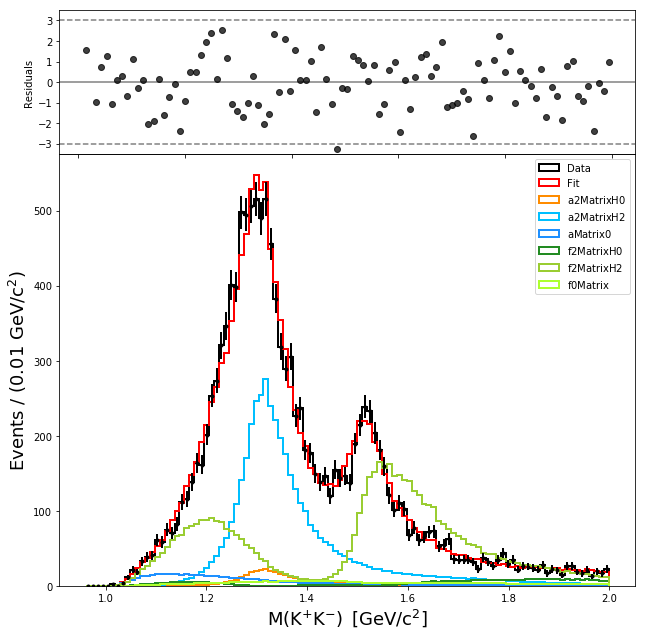

<Figure size 432x288 with 0 Axes>

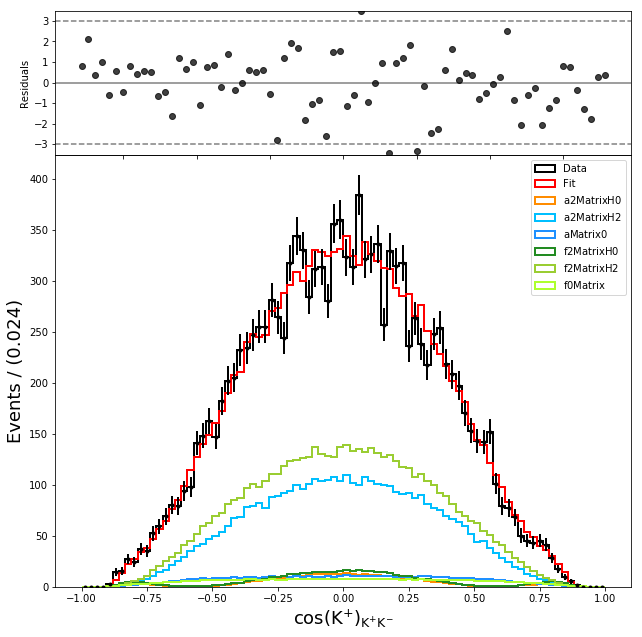

<Figure size 432x288 with 0 Axes>

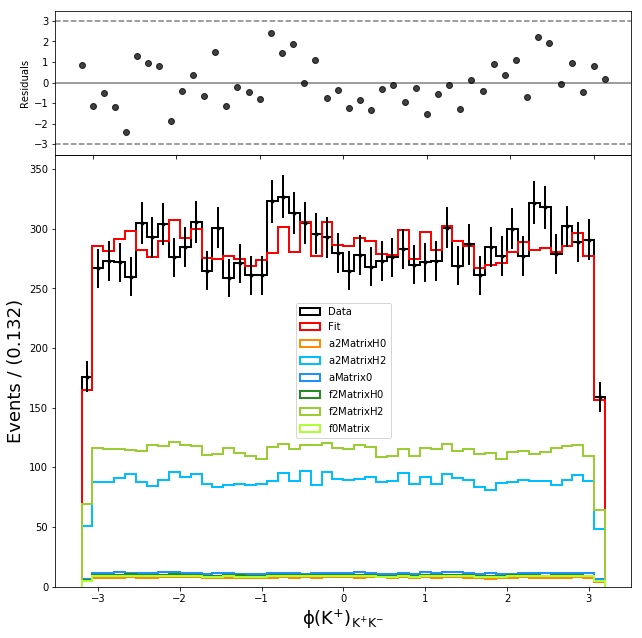

In [10]:
DataFitCompare("/data/jollyj/mkuessner/pwa/coupled_KK_PiEta_PiPi_Scatter/V2_4180_ptfit/qaKK/gamgamToKpKm.cfg")

[array([ 0.08701415, -0.18051487,  0.14957982, ..., -0.24390289,
        0.81115645, -0.76107383]), array([-0.15064873,  0.02720066,  0.09696195, ..., -0.75077325,
        0.04613239,  0.12793149]), array([ 0.10056948,  0.14994252, -0.08001667, ..., -0.64653009,
       -0.35265854, -0.8949396 ]), array([0.24320398, 0.2694729 , 0.23742744, ..., 1.02881885, 0.8946228 ,
       1.18998528])]
[array([-0.06759977,  0.17651421, -0.14947739, ...,  0.25990972,
       -0.78893614,  0.76363564]), array([ 0.15401419, -0.010195  , -0.09198552, ...,  0.75453895,
       -0.04817993, -0.13815258]), array([ 1.40905104e-04,  1.14547811e-01, -6.86994866e-02, ...,
        4.88685668e-01,  8.40710163e-01,  3.34449500e-01]), array([0.21824704, 0.2425352 , 0.22053307, ..., 0.94504374, 1.16243923,
       0.85441542])]


<Figure size 432x288 with 0 Axes>

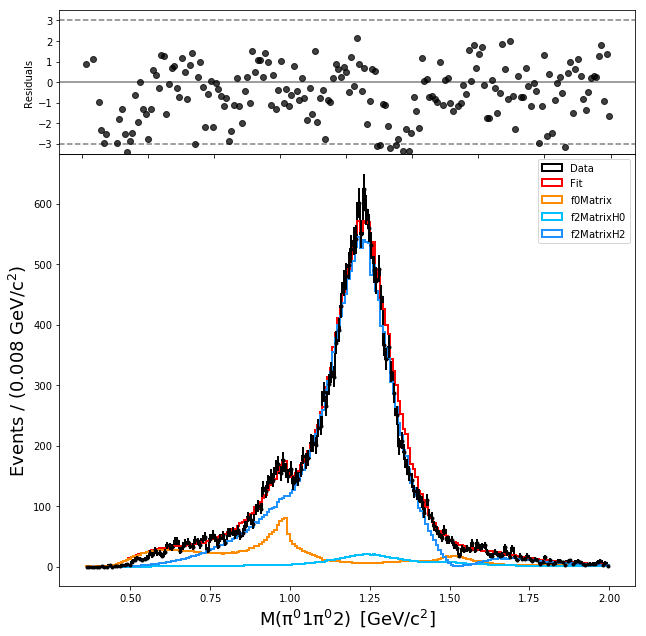

<Figure size 432x288 with 0 Axes>

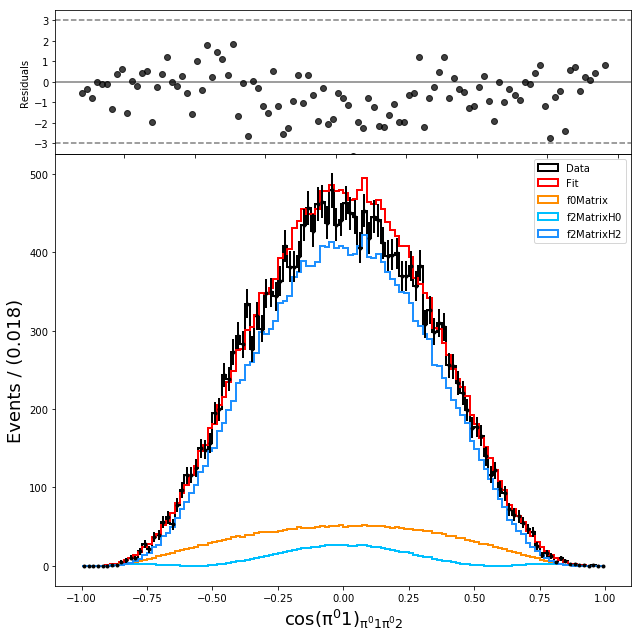

<Figure size 432x288 with 0 Axes>

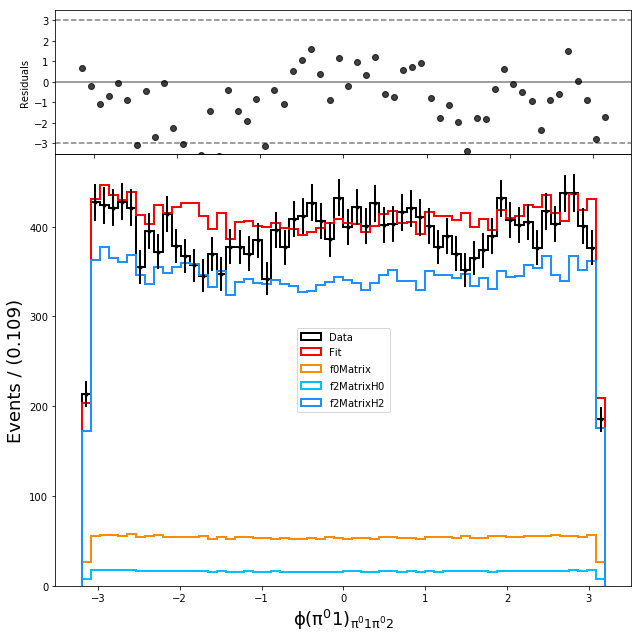

In [16]:
DataFitCompare("work/notebooks/qaPiPi_4180/gamgamToPiPi.cfg")

[array([-0.02547574,  0.06912413,  0.08497836, ...,  0.06535703,
        0.90747565,  0.46422556]), array([ 0.0510571 ,  0.02558937, -0.03077922, ..., -0.89117134,
        0.02503978, -0.72017324]), array([ 0.28659117,  0.31157529, -0.22558844, ..., -0.05729357,
       -0.21771196, -0.81005758]), array([0.3182531 , 0.34923548, 0.27392986, ..., 0.90481704, 0.94088709,
       1.18516695])]
[array([ 0.03882256, -0.07688417, -0.09492538, ..., -0.0459692 ,
       -0.90885234, -0.45010287]), array([-0.06510972, -0.02735111,  0.01158894, ...,  0.88413632,
       -0.05046833,  0.74610251]), array([ 0.15203504,  0.11642899, -0.23303194, ...,  0.75137591,
        0.56995136,  0.15631956]), array([0.2245198 , 0.1897838 , 0.28221929, ..., 1.16930711, 1.08239281,
       0.89538449])]


<Figure size 432x288 with 0 Axes>

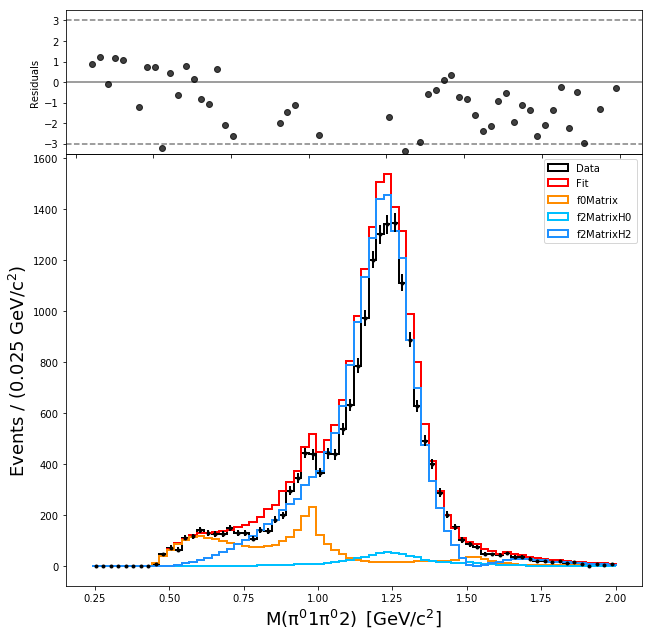

<Figure size 432x288 with 0 Axes>

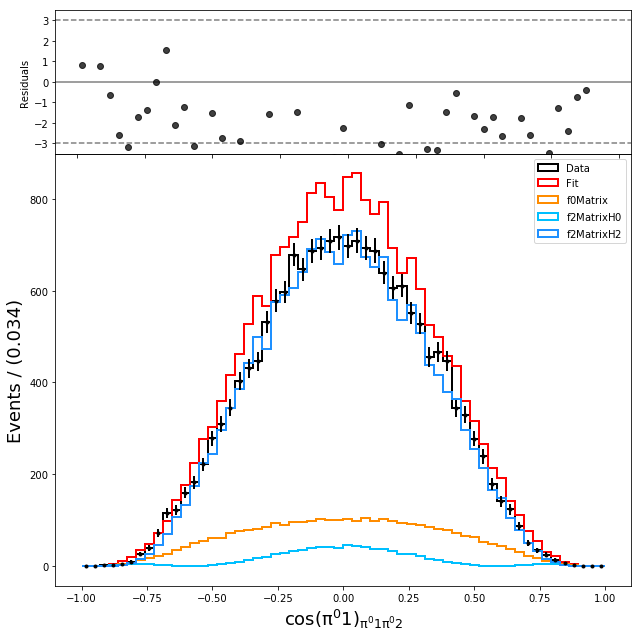

<Figure size 432x288 with 0 Axes>

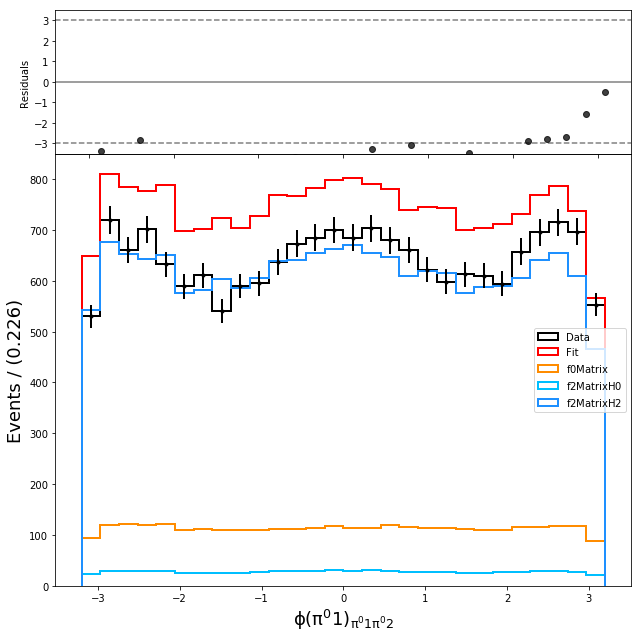

In [22]:
DataFitCompare("work/notebooks/qaPiPi/gamgamToPiPi.cfg")

[array([-0.37809569,  0.01578744,  0.06944999, ..., -0.17304711,
       -0.11967529, -0.42186007]), array([ 0.19861966,  0.3917653 , -0.30622399, ...,  0.31263259,
        0.27353317, -0.03355177]), array([-0.20003013,  0.10878587, -0.24113791, ..., -0.44859827,
       -0.19285816, -0.43695033]), array([0.49054751, 0.42869845, 0.41828534, ..., 0.58918875, 0.38020495,
       0.62308574])]
[array([ 0.42276418,  0.00528423, -0.05348444, ...,  0.13510601,
        0.1348726 ,  0.45582226]), array([-0.2102544 , -0.44589275,  0.31397161, ..., -0.24363372,
       -0.2561506 ,  0.03273025]), array([ 0.03851523, -0.1684939 , -0.29506364, ...,  0.30988386,
       -0.20663238,  0.01320917]), array([0.72427386, 0.72621703, 0.69903797, ..., 0.68832535, 0.65318716,
       0.7135632 ])]


<Figure size 432x288 with 0 Axes>

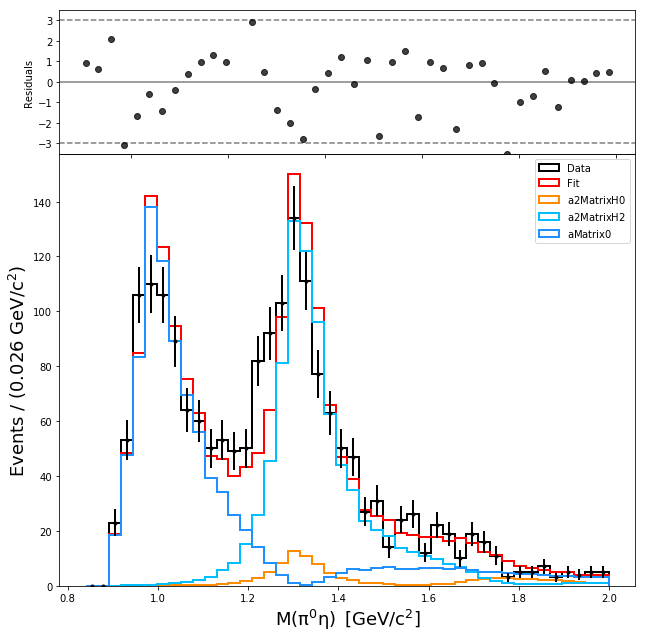

<Figure size 432x288 with 0 Axes>

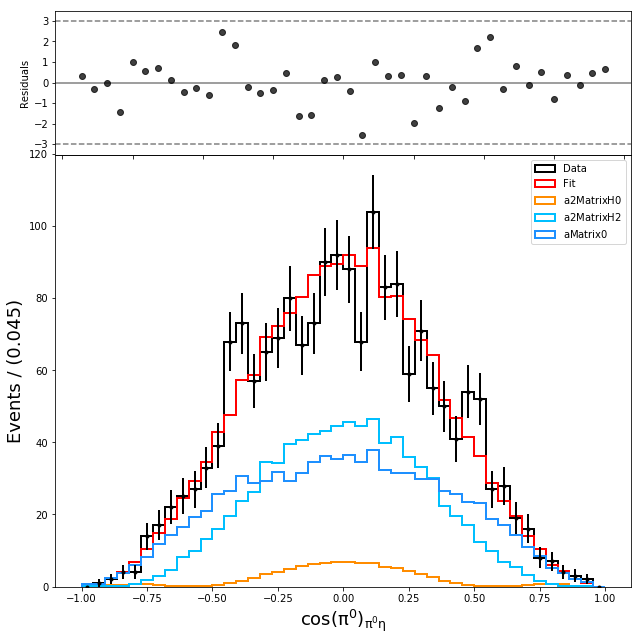

<Figure size 432x288 with 0 Axes>

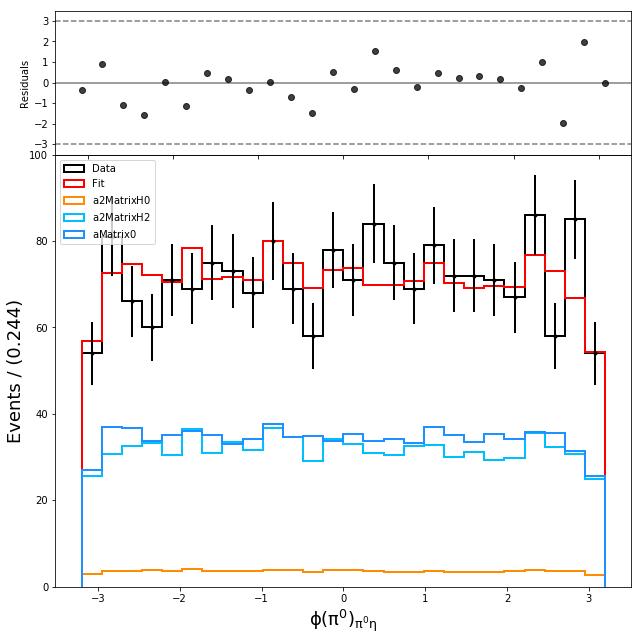

In [28]:
DataFitCompare("work/notebooks/qaPiEta/gamgamToPiEta.cfg")

Jetzt kommt nur ein Test die Sheets zu plotten für eins meiner files...

In [36]:
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
#%matplotlib notebook
# aka import ipympl

import matplotlib.pyplot as plt


file = uproot.open("work/notebooks/TMatrixGeneral.root")
hist = file["sheet_----;1"]

arr=hist.allvalues
nbinsx=len(arr)
nbinsy=len(arr[0])
x_low, y_low = hist.low
x_max, y_max = hist.high
binning_x = (x_max-x_low)/nbinsx
binning_y = (y_max-y_low)/nbinsy

X=[]
Y=[]

bla_x = []

for i in range(0,nbinsx):
    bla_x.append(i*(binning_x)+x_low)

for j in range(0,nbinsy):
    X.append(bla_x)



for i in range(0,nbinsx):
    bla=i*(binning_y)+y_low
    #print(bla)
    bla_y = []
    for j in range(0,nbinsy):
        bla_y.append(bla)
    Y.append(bla_y)
    #print(Y[i][0])

#fig = plt.figure(figsize=(10,5))
#ax = Axes3D(fig)

#ax.plot_surface(X, Y, arr, cmap=cm.viridis, rstride=2, cstride=2)

#plt.show()
    


In [37]:
import ipyvolume as ipv

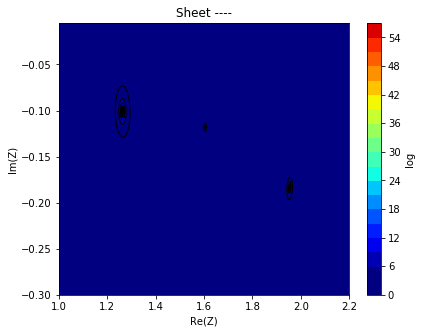

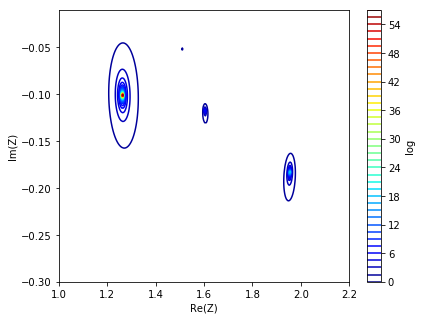

In [66]:

arr=hist.allvalues 
#print(X[0])
Z=arr

#for i in range(0,len(arr)):
#    for j in range(0,len(arr[0])):
#        if arr[i][j] != 0.:
#            Z[i][j]=np.log(arr[i][j])


#bla=Z


Z=Z.transpose()

Norm = cm.colors.Normalize(vmax=60., vmin=5.)

fig, ax = plt.subplots(figsize=(6.5,5))
ax.set_title("Sheet ----")
ax.set_xlim(1., 2.2)
ax.set_xlabel("Re(Z)")
ax.set_ylabel("Im(Z)")

ax.set_ylim(-0.3, -0.005)
surf_plotf = ax.contourf(X, Y, Z, 20, norm=Norm, cmap=cm.jet)
surf_plot = ax.contour(X, Y, Z, 20, colors='black', linewidths=(1.))

cbar = fig.colorbar(surf_plotf)
cbar.ax.set_ylabel("log")

plt.show()


Norm = cm.colors.Normalize(vmax=20., vmin=-1.)

fig, ax = plt.subplots(figsize=(6.5,5))
ax.set_xlim(1., 2.2)
ax.set_xlabel("Re(Z)")
ax.set_ylabel("Im(Z)")

ax.set_ylim(-0.3, -0.01)
surf_plot = ax.contour(X, Y, Z, 50, cmap=cm.jet)

cbar = fig.colorbar(surf_plot)
cbar.ax.set_ylabel("log")

plt.show()


blaX = np.array(X)
blaY = np.array(Y)
blaZ = np.array(Z)

colormap = cm.jet
znorm = blaZ - blaZ.min()+10.
znorm /= znorm.ptp()
znorm.min(), znorm.max()
color = colormap(znorm)

ipv.figure()
surf = ipv.plot_surface(blaX, blaY, blaZ, color=color[...,:3])

ipv.style.box_off()
ipv.pylab.xlim(1.,2.)
ipv.pylab.ylim(-0.4,-0.01)


ipv.show()